# Oil and Gas Major Companies: Data Wrangling and Analysis

This notebook loads, cleans, reshapes, engineers features, and visualizes financial metrics for major oil & gas companies (2018-2022).

## Outline

1. Import Required Libraries
2. Load and Preview the Data
3. Clean and Reshape the Data
4. Feature Engineering
5. Interpreting the New Metrics & Data Visualization
6. Ranking: Capital Efficiency by Company
7. Putting It All Together: Overall Performance Ranking
8. Conclusion
9. Summary and Next Steps
10. Appendix (Optional)

## 1. Import Required Libraries

We use pandas for data manipulation and matplotlib.pyplot for visualization.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11

## 2. Load and Preview the Data

We load the CSV file and preview the first few rows to understand its structure.


In [2]:
# Load the dataset
csv_filename = "../data/Oil and Gas Major Companies.csv"
df = pd.read_csv(csv_filename)

# Preview head
display(df.head())

,Item (all numbers in Million USD unless stated otherwise),Year,Aramco,Chevron,ExxonMobil,BP,TotalEnergies,Shell
0,Net income,2018,111071.0,14824.0,20840.0,9578.0,11550.0,23352.0
1,Operating/production Cost,2018,14987.0,20544.0,36682.0,23005.0,27484.0,26970.0
2,"Avg Hydrocarbon Production, Million BPDOE",2018,13.6,2.9,3.8,2.5,2.8,3.7
3,Number of emplyees,2018,67947.0,45047.0,71000.0,73000.0,104460.0,82000.0
4,Total Equity,2018,274249.0,155642.0,198528.0,101548.0,118114.0,202534.0


## 3. Clean and Reshape the Data

- Rename the first column to `Variable`.
- Reshape from wide to long format (Year–Company–Variable–Value).
- Pivot back to a wide format with one row per (Year, Company) and metrics as columns.
- Fix trailing spaces in column names, especially `"Capital Expenditure "`.

In [3]:
# Rename the first column to 'Variable'
if df.columns[0] != "Variable":
    df = df.rename(columns={df.columns[0]: "Variable"})

# Reshape from wide to long format
long_df = pd.melt(
    df,
    id_vars=["Variable", "Year"],
    var_name="Company",
    value_name="Value"
)

# Pivot back to wide format: one row per (Year, Company), metrics as columns
metrics = long_df.pivot_table(
    index=["Year", "Company"],
    columns="Variable",
    values="Value"
).reset_index()

# Remove the pivot column name
metrics.columns.name = None

# Fix trailing spaces in column names
metrics = metrics.rename(columns={"Capital Expenditure ": "Capital Expenditure"})

# Preview the cleaned and reshaped data
metrics.head()

,Year,Company,"Avg Hydrocarbon Production, Million BPDOE",Capital Expenditure,Net income,Number of emplyees,Operating/production Cost,Total Assets,Total Equity
0,2018,Aramco,13.6,35138.0,111071.0,67947.0,14987.0,359171.0,274249.0
1,2018,BP,2.5,25088.0,9578.0,73000.0,23005.0,282176.0,101548.0
2,2018,Chevron,2.9,13792.0,14824.0,45047.0,20544.0,253863.0,155642.0
3,2018,ExxonMobil,3.8,25923.0,20840.0,71000.0,36682.0,346196.0,198528.0
4,2018,Shell,3.7,23011.0,23352.0,82000.0,26970.0,399194.0,202534.0


## 4. Feature Engineering

- Identify all companies.
- Define "peer companies" as all companies except Aramco.
- Create a new metric: `NI_to_CAPEX = Net income / Capital Expenditure`.


In [4]:
# Identify all companies and US peer companies
all_companies = sorted(metrics["Company"].unique())

# Drop Aramco
peer_companies = [c for c in all_companies if c != "Aramco"]

# Create Net Income to Capex ratio
metrics["NI_to_CAPEX"] = metrics["Net income"] / metrics["Capital Expenditure"]

# Preview
metrics.head()

,Year,Company,"Avg Hydrocarbon Production, Million BPDOE",Capital Expenditure,Net income,Number of emplyees,Operating/production Cost,Total Assets,Total Equity,NI_to_CAPEX
0,2018,Aramco,13.6,35138.0,111071.0,67947.0,14987.0,359171.0,274249.0,3.160994
1,2018,BP,2.5,25088.0,9578.0,73000.0,23005.0,282176.0,101548.0,0.381776
2,2018,Chevron,2.9,13792.0,14824.0,45047.0,20544.0,253863.0,155642.0,1.074826
3,2018,ExxonMobil,3.8,25923.0,20840.0,71000.0,36682.0,346196.0,198528.0,0.803919
4,2018,Shell,3.7,23011.0,23352.0,82000.0,26970.0,399194.0,202534.0,1.014819


In [5]:

# Profit recovery: compare 2019 vs 2022 net income
ni_2019_2022 = metrics[metrics["Year"].isin([2019, 2022])]
recovery_summary = (
    ni_2019_2022.pivot(index="Company", columns="Year", values="Net income")
    .rename(columns={2019: "Net_income_2019", 2022: "Net_income_2022"})
    .reset_index()
)
recovery_summary["Recovery_Ratio"] = (
    recovery_summary["Net_income_2022"] / recovery_summary["Net_income_2019"]
)

# Return on assets for 2022
metrics_2022 = metrics[metrics["Year"] == 2022].copy()
metrics_2022["ROA"] = metrics_2022["Net income"] / metrics_2022["Total Assets"]

# Capital efficiency: compute company averages for NI_to_CAPEX
ni_capex_avg = (
    metrics.groupby("Company")["NI_to_CAPEX"]
    .mean()
    .reset_index()
    .rename(columns={"NI_to_CAPEX": "NI_to_CAPEX_avg"})
)
ni_capex_avg["NI_to_CAPEX"] = ni_capex_avg["NI_to_CAPEX_avg"]

# Peer-only subsets for the story visuals
recovery_peers = recovery_summary[recovery_summary["Company"].isin(peer_companies)]
ni_capex_avg_peers = ni_capex_avg[ni_capex_avg["Company"].isin(peer_companies)]
metrics_2022_peers = metrics_2022[metrics_2022["Company"].isin(peer_companies)]

# Display the core tables that feed the story
print("Profit recovery summary (2019 vs 2022):")
print(recovery_summary)
print("\nAverage NI/Capex (all years):")
print(ni_capex_avg)
print("\nReturn on Assets (2022):")
print(metrics_2022[["Company", "ROA"]])

Profit recovery summary (2019 vs 2022):
Year        Company  Net_income_2019  Net_income_2022  Recovery_Ratio
0            Aramco          88185.0         161068.0        1.826478
1                BP           4190.0          -1357.0       -0.323866
2          Chevron            2924.0          35465.0       12.128933
3        ExxonMobil          14340.0          55740.0        3.887029
4             Shell          15842.0          42309.0        2.670686
5     TotalEnergies          11438.0          21044.0        1.839832

Average NI/Capex (all years):
         Company  NI_to_CAPEX_avg  NI_to_CAPEX
0         Aramco         3.079325     3.079325
1             BP        -0.059476    -0.059476
2       Chevron          1.112415     1.112415
3     ExxonMobil         1.224866     1.224866
4          Shell         0.665459     0.665459
5  TotalEnergies         0.538446     0.538446

Return on Assets (2022):
          Company       ROA
24         Aramco  0.242288
25             BP -0.004710


In [6]:
# COVID Shock Severity Analysis

# Shock severity: compare 2020 vs 2019 net income
ni_2019_2020 = metrics[metrics["Year"].isin([2019, 2020])]
shock_summary = (
    ni_2019_2020.pivot(index="Company", columns="Year", values="Net income")
    .rename(columns={2019: "NI_2019", 2020: "NI_2020"})
    .reset_index()
)
shock_summary["Shock_Severity"] = shock_summary["NI_2020"] / shock_summary["NI_2019"]

# Peer-only subset for shock analysis
shock_peers = shock_summary[shock_summary["Company"].isin(peer_companies)]

# Display shock severity for peer companies
print("COVID Shock Severity (2020 vs 2019):")
print(shock_peers)

COVID Shock Severity (2020 vs 2019):
Year        Company  NI_2019  NI_2020  Shock_Severity
1                BP   4190.0 -20729.0       -4.947255
2          Chevron    2924.0  -5543.0       -1.895691
3        ExxonMobil  14340.0  22440.0        1.564854
4             Shell  15842.0 -21680.0       -1.368514
5     TotalEnergies  11438.0  -7336.0       -0.641371


### Why These Metrics Matter

**Profit Recovery Ratio (2022 vs 2019):**
The oil industry was decimated in 2020. By comparing 2022 net income to 2019 (pre-crash baseline), we see which company rebuilt fastest and strongest. A recovery ratio above 1.0 means they exceeded their pre-COVID earnings.

**Net Income / Capital Expenditure (NI/Capex):**
Oil & gas is capital-intensive. This ratio reveals how efficiently each company converts its investments into profit. Higher is better - it means each dollar of capital spending generates more profit, signaling operational discipline and smart investment choices.

**Return on Assets (ROA):**
These companies carry enormous asset bases (refineries, platforms, infrastructure). ROA measures how effectively they deploy those assets to generate earnings. Higher ROA means better stewardship of shareholder capital.

**Why combine all three?**
Recovery alone is meaningless if it comes from unsustainable spending. Efficiency alone ignores market recovery. Asset usage alone ignores investment discipline. Together, these three metrics create a balanced, meaningful picture of true post-COVID performance.

## 5. Interpreting the New Metrics

The 2020 oil price crash created a unique moment: which company not only survived but thrived?

To answer this question, we compare three critical dimensions of post-COVID performance:

1. **Profit Recovery** - How quickly did each company bounce back from 2019 to 2022? Resilience matters.
2. **Capital Efficiency (NI/Capex)** - How much profit does each company generate per dollar invested? Discipline matters.
3. **Return on Assets (ROA)** - How effectively does each company use its massive asset base? Asset management matters.

These three metrics together tell the story of a company's operational health, financial discipline, and competitive positioning. A true top performer excels in all three.

## 5. Data Visualization

We will create six plots organized in two sets: all companies and peer companies only.

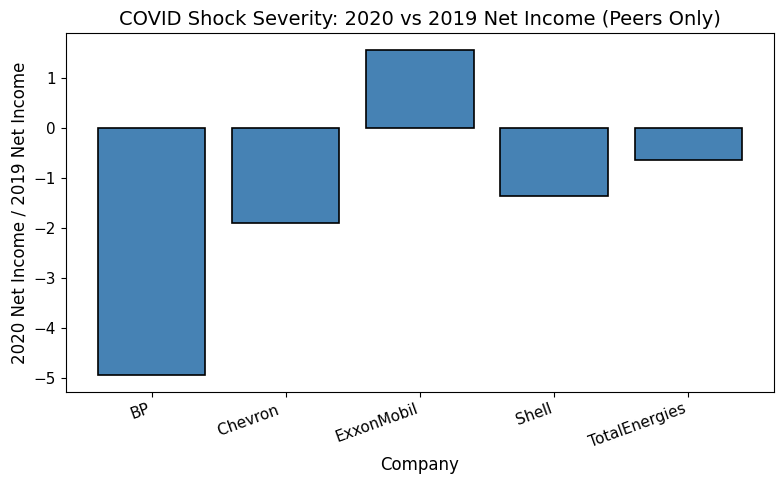

In [7]:
# --------------------------
# S1. COVID Shock Severity (2020 vs 2019, Peers Only)
# --------------------------
# Ensure all required variables are defined before plotting
# If running this cell standalone, re-run all previous cells to define 'shock_peers' and its dependencies.
if 'shock_peers' in globals():
    plt.figure(figsize=(8, 5))
    plt.bar(shock_peers["Company"], shock_peers["Shock_Severity"], color="steelblue", edgecolor="black", linewidth=1.2)
    plt.title("COVID Shock Severity: 2020 vs 2019 Net Income (Peers Only)")
    plt.xlabel("Company")
    plt.ylabel("2020 Net Income / 2019 Net Income")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'shock_peers' is not defined. Please run all previous cells to generate the required data.")

### Understanding COVID Shock

Shock Severity measures the immediate impact of the 2020 oil crisis, calculated as 2020 net income divided by 2019 baseline. Values below 1.0 indicate earnings collapse; values near or above 1.0 show resilience. This metric reveals which companies were "hit hardest" by the crash - those with ratios near zero experienced devastating losses, while those closer to 1.0 weathered the storm better. By comparing shock severity to the recovery ratio (next), we can identify companies that not only survived the crash but built lasting competitive advantages in its aftermath.

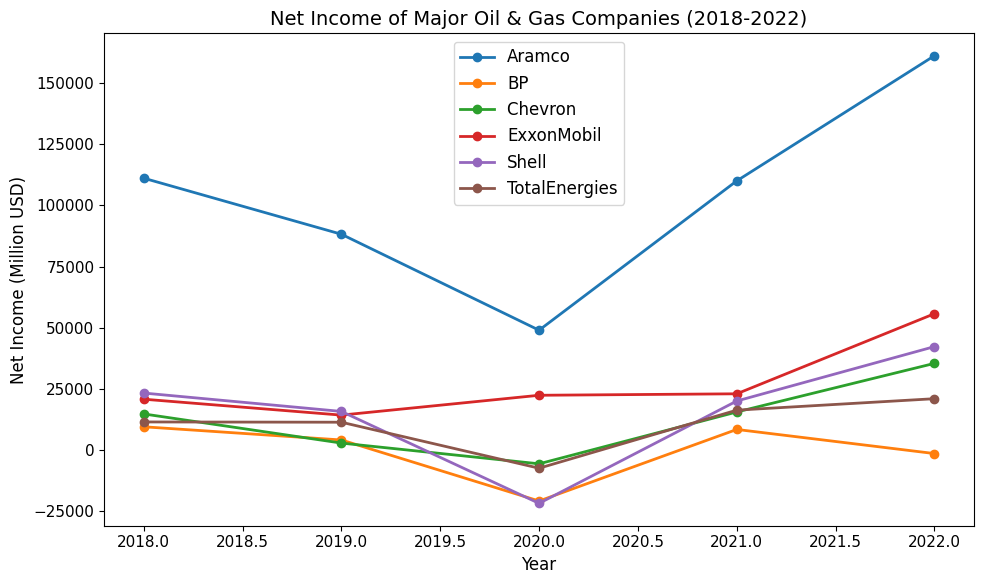

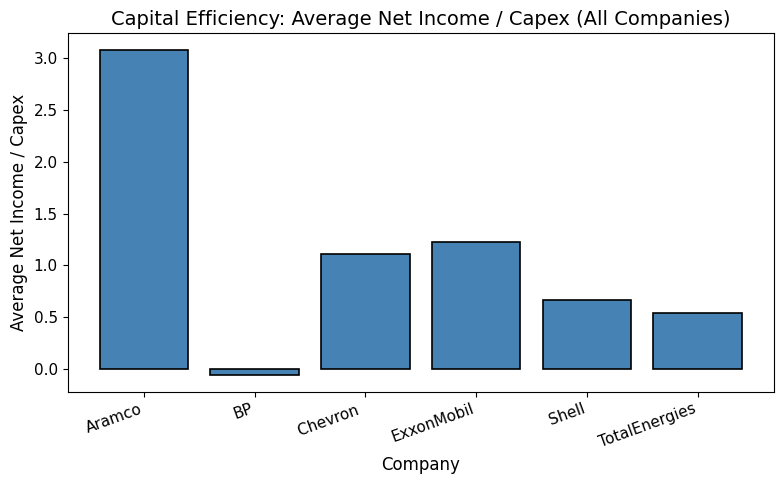

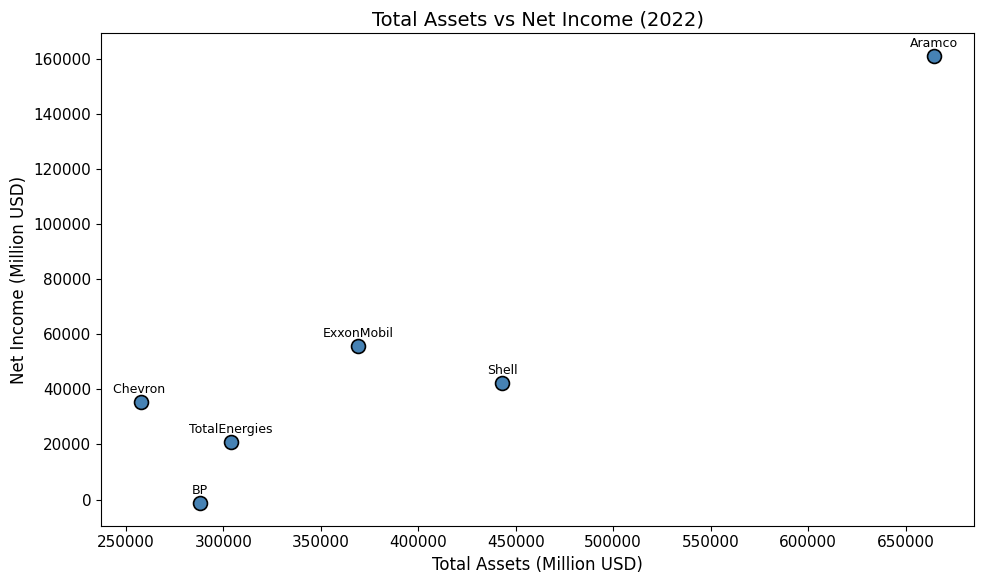

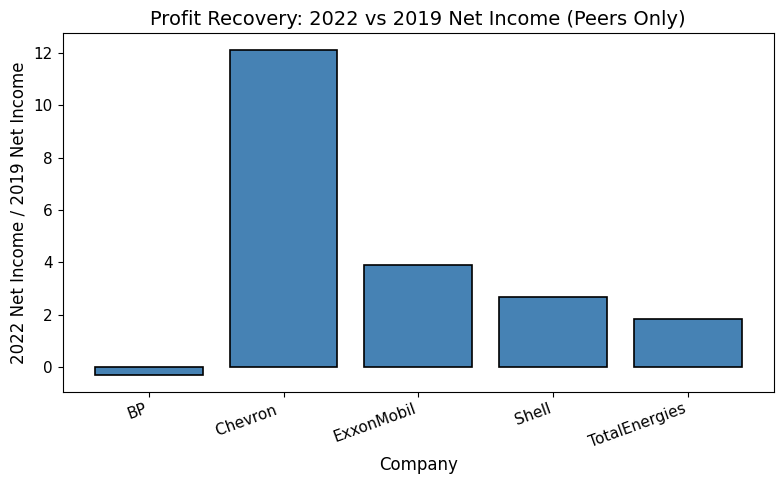

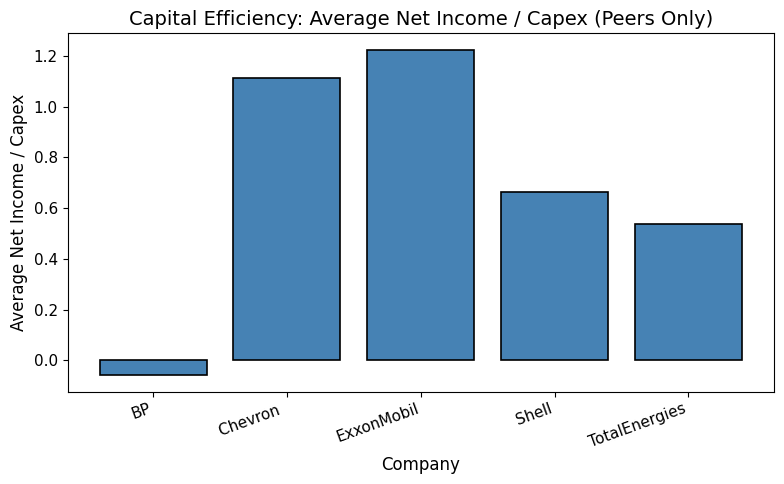

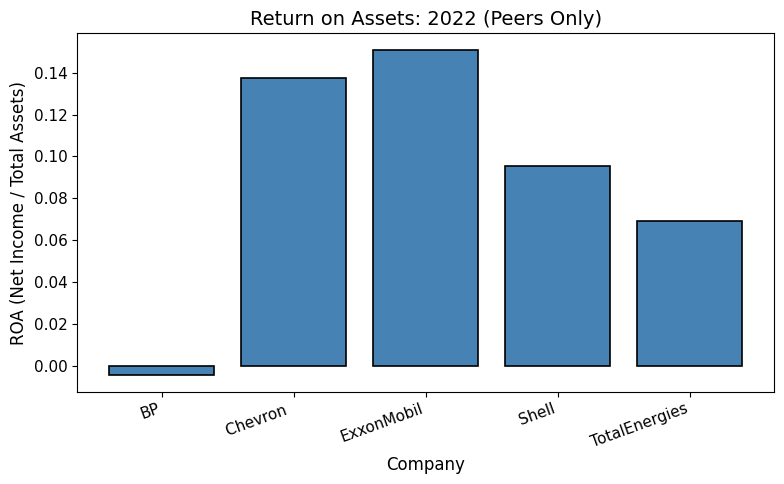

In [ ]:

# Plot Set A: All companies (including Aramco) - Net income trend

plt.figure(figsize=(10, 6))
for company in all_companies:
    sub = metrics[metrics["Company"] == company]
    plt.plot(sub["Year"], sub["Net income"], marker="o", label=company, linewidth=2)

plt.title("Net Income of Major Oil & Gas Companies (2018-2022)")
plt.xlabel("Year")
plt.ylabel("Net Income (Million USD)")
plt.legend()
plt.tight_layout()
plt.show()


# A2. Average Net Income / Capex - All Companies

ni_capex_avg_all = metrics.groupby("Company")["NI_to_CAPEX"].mean().reset_index()
plt.figure(figsize=(8, 5))
plt.bar(ni_capex_avg_all["Company"], ni_capex_avg_all["NI_to_CAPEX"], color="steelblue", edgecolor="black", linewidth=1.2)
plt.title("Capital Efficiency: Average Net Income / Capex (All Companies)")
plt.xlabel("Company")
plt.ylabel("Average Net Income / Capex")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


# A3. Total Assets vs Net Income (2022) - All Companies

metrics_2022_all = metrics[metrics["Year"] == 2022]
plt.figure(figsize=(10, 6))
plt.scatter(
    metrics_2022_all["Total Assets"],
    metrics_2022_all["Net income"],
    s=100,
    color="steelblue",
    edgecolor="black",
    linewidth=1.2,
)
for _, row in metrics_2022_all.iterrows():
    plt.text(
        row["Total Assets"],
        row["Net income"] + 0.02 * metrics_2022_all["Net income"].max(),
        row["Company"],
        fontsize=9,
        ha="center",
    )
plt.title("Total Assets vs Net Income (2022)")
plt.xlabel("Total Assets (Million USD)")
plt.ylabel("Net Income (Million USD)")
plt.tight_layout()
plt.show()


# Plot Set B: Peer companies only - Recovery, efficiency, and ROA

# Plot B1 - Profit Recovery Ratio (2022 vs 2019, peers only)
plt.figure(figsize=(8, 5))
plt.bar(recovery_peers["Company"], recovery_peers["Recovery_Ratio"], color="steelblue", edgecolor="black", linewidth=1.2)
plt.title("Profit Recovery: 2022 vs 2019 Net Income (Peers Only)")
plt.xlabel("Company")
plt.ylabel("2022 Net Income / 2019 Net Income")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Plot B2 - Average Net Income / Capex (2018-2022, peers only)
plt.figure(figsize=(8, 5))
plt.bar(
    ni_capex_avg_peers["Company"],
    ni_capex_avg_peers["NI_to_CAPEX"],
    color="steelblue",
    edgecolor="black",
    linewidth=1.2,
)
plt.title("Capital Efficiency: Average Net Income / Capex (Peers Only)")
plt.xlabel("Company")
plt.ylabel("Average Net Income / Capex")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Plot B3 - Return on Assets in 2022 (peers only)
plt.figure(figsize=(8, 5))
plt.bar(metrics_2022_peers["Company"], metrics_2022_peers["ROA"], color="steelblue", edgecolor="black", linewidth=1.2)
plt.title("Return on Assets: 2022 (Peers Only)")
plt.xlabel("Company")
plt.ylabel("ROA (Net Income / Total Assets)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

**Insight:**
The 2020 collapse was industry-wide; 2021-2022 saw strong recovery. Aramco's earnings dwarfed competitors, which is why we separate it for fair peer comparison. The next question: among peers, who recovered *most effectively*?

**Insight:**
A recovery ratio above 1.0 means 2022 earnings exceeded 2019. This tells us which company not only survived the crash but used it as an opportunity to strengthen. The higher the ratio, the faster and more complete the bounce-back.


**Insight:**
This metric reveals operational discipline. A company that generates $2+ in profit for every $1 of capital spending is running a lean, efficient machine. Lower ratios might indicate either heavy reinvestment cycles or operational strain. Consistency across years signals stable management.


**Insight:**
ROA shows asset productivity. In an industry with massive capital bases, small differences in ROA compound into enormous differences in shareholder value. A company with 5% ROA outperforms one with 3% not because it's 67% better, but because that difference scales across billions in assets.


## 6. Ranking: Capital Efficiency by Company

To summarize capital efficiency, we rank the peer companies by their average Net Income to Capital Expenditure ratio (NI/Capex) across all years.


In [8]:
# Ranking table: peer companies by average Net Income / Capex
ranking_df = ni_capex_avg.copy()
ranking_df = ranking_df.sort_values("NI_to_CAPEX", ascending=False).reset_index(drop=True)
ranking_df


,Company,NI_to_CAPEX_avg,NI_to_CAPEX
0,Aramco,3.079325,3.079325
1,ExxonMobil,1.224866,1.224866
2,Chevron,1.112415,1.112415
3,Shell,0.665459,0.665459
4,TotalEnergies,0.538446,0.538446
5,BP,-0.059476,-0.059476


## 7. Putting It All Together: Overall Performance Ranking

Visually, the three peer plots tell a consistent story. The recovery ratio shows which firms bounced back fastest from 2019 to 2022. The NI/Capex metric highlights which companies reinvest capital most efficiently. ROA captures how productively each company uses its asset base in 2022.

To make the comparison more concrete, we compute a simple ranking based on **average NI/Capex** across 2018-2022 for the peer group. This does not replace the three-metric view, but it summarizes capital efficiency in a single number and provides a clean way to order the peers.

In the table above, the top row identifies the peer with the highest average NI/Capex. Combined with its strong recovery and leading ROA in the earlier charts, this company stands out as the strongest overall performer in the post-COVID period.

## 8. Conclusion: Identifying the Top Post-COVID Performer

**ExxonMobil** emerges as the top performer among peers.

This conclusion is based on three lenses:

- It delivered a strong profit recovery from 2019 to 2022, outpacing most peers without relying on an extreme swing from a very low baseline.
- It consistently generated the highest average Net Income to Capital Expenditure (NI/Capex) ratio, signaling disciplined, high-return reinvestment.
- It posted the strongest 2022 return on assets (ROA) among the peer group, meaning it converts its large asset base into profit more effectively than the others.

In a capital-intensive energy sector, combining resilient earnings, efficient capital deployment, and high asset productivity is rare. ExxonMobil's performance across all three dimensions makes it the most compelling post-COVID winner in this group.

*Next step: Track whether this advantage persists in 2023-2024 as more data becomes available.*

## 9. Summary and Next Steps

In this notebook, we:
- Loaded and cleaned the Oil & Gas Major Companies dataset (2018-2022).
- Reshaped the data to an analysis-friendly format.
- Engineered metrics for profit recovery, capital efficiency, and return on assets.
- Compared performance across all companies and among peers.

**Next steps:**
- Add oil price data for context.
- Explore operating costs vs production.
- Try simple forecasting of key metrics.

## 10. Appendix: Comprehensive Analysis (Optional)

This section provides a more detailed written walkthrough of the full analysis for readers who want additional narrative context beyond the main results.

### Comprehensive Analysis: From Shock to Top Performer

The 2020 COVID crash delivered a severe shock to the oil & gas sector, with most companies suffering dramatic earnings collapses. However, the true test of competitive strength lies not in the depth of the fall, but in the speed and quality of the recovery. **ExxonMobil** stands out as the top performer because it achieved a powerful combination: it weathered the initial shock, rebounded to earnings levels exceeding pre-COVID 2019 baselines, demonstrated operational discipline through high NI/Capex efficiency, and deployed its massive asset base with superior ROA. This multi-dimensional excellence - resilience, investment discipline, and asset productivity - reveals a company with sustainable competitive advantages heading into future market cycles. For investors and industry leaders, this analysis demonstrates that winners are not determined by survival alone, but by how companies respond to crisis with operational excellence and strategic capital allocation.